In [1]:
import matplotlib.pyplot as plt
import gym
import csv
import random
import logging
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from keras.callbacks import CSVLogger

2021-07-18 20:58:05.121820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-18 20:58:05.121840: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8, 8), strides=(4, 4),
              activation='relu', input_shape=(3, height, width, channels)))
    model.add(Convolution2D(64, (4, 4), strides=(2, 2), activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [3]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(
    ), attr='eps', value_max=1, value_min=.1, value_test=.2, nb_steps=1000000)
    memory = SequentialMemory(limit=10000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                   enable_dueling_network=True, dueling_type='avg',
                   nb_actions=actions, nb_steps_warmup = 1000000)
    return dqn

In [4]:
env = gym.make("Freeway-v0")
env = gym.wrappers.ResizeObservation(env, (88, 88))
height, width, channels = env.observation_space.shape
actions = env.action_space.n
model = build_model(height, width, channels, actions)

In [5]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 21, 21, 32)     6176      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 9, 9, 64)       32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 7, 7, 64)       36928     
_________________________________________________________________
flatten (Flatten)            (None, 9408)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4817408   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 7

In [6]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=0.01))
log = dqn.fit(env, nb_steps=1000000, visualize=True, verbose=2)

127/1000000: episode: 279, duration: 20.739s, episode steps: 2715, steps per second: 131, episode reward: 14.000, mean reward:  0.005 [ 0.000,  1.000], mean action: 1.002 [0.000, 2.000],  loss: --, mean_q: --, mean_eps: --
 764858/1000000: episode: 280, duration: 20.218s, episode steps: 2731, steps per second: 135, episode reward: 17.000, mean reward:  0.006 [ 0.000,  1.000], mean action: 0.996 [0.000, 2.000],  loss: --, mean_q: --, mean_eps: --
 767583/1000000: episode: 281, duration: 17.783s, episode steps: 2725, steps per second: 153, episode reward: 17.000, mean reward:  0.006 [ 0.000,  1.000], mean action: 0.993 [0.000, 2.000],  loss: --, mean_q: --, mean_eps: --
 770310/1000000: episode: 282, duration: 19.294s, episode steps: 2727, steps per second: 141, episode reward: 17.000, mean reward:  0.006 [ 0.000,  1.000], mean action: 1.014 [0.000, 2.000],  loss: --, mean_q: --, mean_eps: --
 773040/1000000: episode: 283, duration: 17.845s, episode steps: 2730, steps per second: 153, ep

In [7]:
scores = dqn.test(env, nb_episodes = 10, visualize=True)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 21.000, steps: 2737
Episode 2: reward: 22.000, steps: 2743
Episode 3: reward: 21.000, steps: 2732
Episode 4: reward: 21.000, steps: 2735
Episode 5: reward: 24.000, steps: 2726
Episode 6: reward: 24.000, steps: 2713
Episode 7: reward: 21.000, steps: 2714
Episode 8: reward: 21.000, steps: 2750
Episode 9: reward: 21.000, steps: 2710
Episode 10: reward: 21.000, steps: 2736
21.7


In [8]:
env.close()
dqn.save_weights('1M_dqn.h5f')

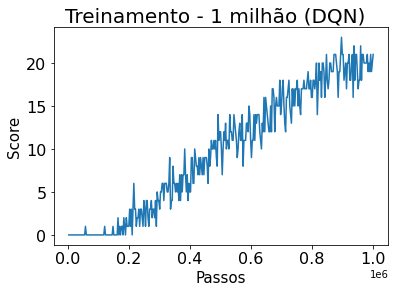

In [14]:
plt.figure()
plt.figtext(.5,.9,'Treinamento - 1 milhão (DQN)', fontsize=20, ha='center')
plt.xlabel('Passos', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.plot(log.history['nb_steps'], log.history['episode_reward'])
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.show()

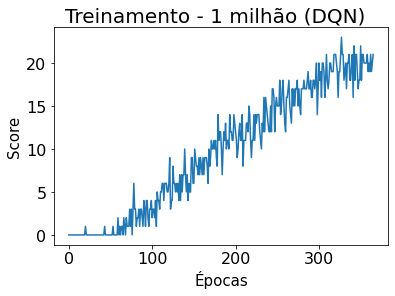

In [15]:
plt.figure()
plt.figtext(.5,.9,'Treinamento - 1 milhão (DQN)', fontsize=20, ha='center')
plt.xlabel('Épocas', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.plot(log.epoch, log.history['episode_reward'])
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.show()

Text(0, 0.5, 'Score')

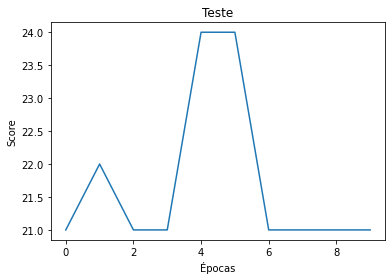

In [11]:
plt.plot(scores.epoch, scores.history['episode_reward'])
plt.title("Teste")
plt.xlabel("Épocas")
plt.ylabel("Score")

In [12]:
np.max(log.history['episode_reward'])

23.0

In [13]:
log.history

{'episode_reward': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  2.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  2.0,
  1.0,
  0.0,
  2.0,
  1.0,
  1.0,
  1.0,
  3.0,
  1.0,
  3.0,
  0.0,
  3.0,
  6.0,
  3.0,
  3.0,
  1.0,
  2.0,
  2.0,
  3.0,
  1.0,
  3.0,
  3.0,
  2.0,
  1.0,
  4.0,
  3.0,
  1.0,
  4.0,
  4.0,
  2.0,
  1.0,
  3.0,
  3.0,
  4.0,
  2.0,
  3.0,
  3.0,
  2.0,
  4.0,
  1.0,
  5.0,
  4.0,
  4.0,
  3.0,
  5.0,
  5.0,
  6.0,
  6.0,
  4.0,
  6.0,
  6.0,
  6.0,
  5.0,
  5.0,
  6.0,
  9.0,
  3.0,
  4.0,
  4.0,
  8.0,
  6.0,
  6.0,
  5.0,
  6.0,
  5.0,
  6.0,
  4.0,
  7.0,
  4.0,
  7.0,
  5.0,
  7.0,
  7.0,
  10.0,
 